In [429]:
%matplotlib inline

from larch import numpy
import lmfit
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import pandas as pd
import matplotlib.cm as cm


df = pd.read_csv('./Pre-edge_norm_20C0-7.nor', sep=r"\s+")
xlen,ylen = df.shape
ylen = ylen

df2 = pd.read_csv('./Pre-edge_norm_40C0-13.nor', sep=r"\s+")
xlen2,ylen2 = df2.shape
ylen2 = ylen2

df_ruby = pd.read_csv('./rubyred_fe2-0_2eV_fe3+0_9eV.xmu', sep=r"\s+")
xlen2,ylen2 = df2.shape
ylen2 = ylen2

print(df.keys(), df2.keys(), df_ruby.keys())

Index(['energy', 'X20C0', 'X20C1', 'X20C2', 'X20C5', 'X20C6', 'X20C7', 'X20C4',
       'X20C3'],
      dtype='object') Index(['energy', 'X40C01', 'X40C03', 'X40C04', 'X40C06', 'X40C07', 'X40C08',
       'X40C09', 'X40C10', 'X40C11', 'X40C12', 'X40C05', 'X40C02', 'X40C00'],
      dtype='object') Index(['energy', 'RubRed_Ferrous', 'RubRed_Ferric'], dtype='object')


In [430]:
start = 7110
stop = 7116

#Get model pre-dge data
temp = df_ruby[(df_ruby['energy'] > start)]
df_ruby= temp[(df_ruby['energy'] < stop)]
energy = df_ruby['energy']
ferric = df_ruby['RubRed_Ferric']
ferrous = df_ruby['RubRed_Ferrous']

#Interpolate data series to energy of model
itr = zip(df2.keys()[0::2], df2.keys()[1::2])
interp40 = {key : numpy.interp(energy, df2['energy'], value) for key, value in df2.items() if 'energy' not in key}
#itr = zip(df.keys()[0::2], df.keys()[1::2])
interp20 = {key : numpy.interp(energy, df['energy'], value) for key, value in df.items() if 'energy' not in key}

C:\Users\arthurz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [431]:
# create a set of Parameters
params = lmfit.Parameters()
params.add('ferric', value=0.5, min=0, max=1)
params.add('ferrous', value=0.5, min=0, max=1)

# define objective function for fit residual
def resid(pars, data=None, eps=None):
    model = pars['ferric']*ferric + pars['ferrous']*ferrous
    if eps is None:
        return model - data
    return (model - data)/eps



                      Series | Percent Fe (Error) |  chisq
--------------------------------------------------------------
                    X40C00   |   41.7  +/-   10.1 | 0.003282
                    X40C01   |   44.9  +/-    9.9 | 0.003519
                    X40C02   |   39.1  +/-    8.9 | 0.002540
                    X40C03   |   50.1  +/-    4.2 | 0.001071
                    X40C04   |   59.6  +/-    7.9 | 0.003344
                    X40C05   |   70.1  +/-    7.5 | 0.002727
                    X40C06   |   70.4  +/-    6.3 | 0.002827
                    X40C07   |   70.4  +/-    7.2 | 0.003563
                    X40C08   |   64.2  +/-    5.6 | 0.002351
                    X40C09   |   79.3  +/-    8.6 | 0.005205
                    X40C10   |   76.7  +/-    7.5 | 0.004528
                    X40C11   |   79.8  +/-    7.1 | 0.003422
                    X40C12   |   74.7  +/-    7.7 | 0.004433
--------------------------------------------------------------
Average Std Error: 7.0

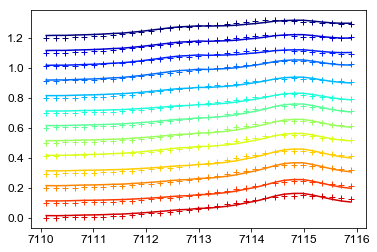

In [454]:

eps = 1

##Calculate Fe3+ content:
result40 = {}

colors = iter(cm.jet(numpy.linspace(0, 1, int(ylen2))))
fmt = ' %25s   | %6.1f  +/- %6.1f | %6.6f'
print('%28s | %10s | %6s' % ("Series","Percent Fe (Error)","chisq"))
print("--------------------------------------------------------------")
for ct, (key, value) in enumerate(sorted(interp40.items())):
    data = numpy.array(value)
    # do fit, here with leastsq model
    minner = lmfit.Minimizer(resid, params, fcn_args=(data, eps))
    result = minner.minimize()
    Fe2 = result.params['ferrous']
    Fe3 = result.params['ferric']
    percent_ferric = Fe3.value / (Fe3.value + Fe2.value) * 100
    B = (numpy.sqrt((Fe3.stderr)**2 + (Fe2.stderr)**2)/ (Fe3.value + Fe2.value))**2
    A = (Fe3.stderr / Fe3.value)**2
    percent_err = 100*numpy.sqrt(A + B)
    print(fmt % (key, percent_ferric, percent_err, result.chisqr))
    result40[key] = (percent_ferric, percent_err, result.chisqr)
    final = data + result.residual * eps
    offset = (ylen2 -2-ct)*0.1
    color = next(colors)
    plt.plot(energy, data + offset, 'k+',color=color )
    plt.plot(energy, final + offset, 'r', color=color)
plt.plot()
p = numpy.sum([x[1] for key,x in result40.items()]) / ylen2
ferric40 = numpy.array([x[0] for key,x in result40.items()])
ferror40 = numpy.array([x[1] for key,x in result40.items()])
print("--------------------------------------------------------------")
print("Average Std Error: " + str(p))

                      Series | Percent Fe (Error) |  chisq
--------------------------------------------------------------
                     X20C0   |   30.8  +/-    6.2 | 0.001202
                     X20C1   |   34.3  +/-    8.5 | 0.001943
                     X20C2   |   45.6  +/-    7.0 | 0.001790
                     X20C3   |   51.3  +/-    7.4 | 0.002403
                     X20C4   |   68.5  +/-    6.0 | 0.002062
                     X20C5   |   69.3  +/-    6.8 | 0.002621
                     X20C6   |   72.0  +/-    7.1 | 0.002757
                     X20C7   |   72.9  +/-    6.4 | 0.002271
--------------------------------------------------------------
Average Std Error: 3.95688785848


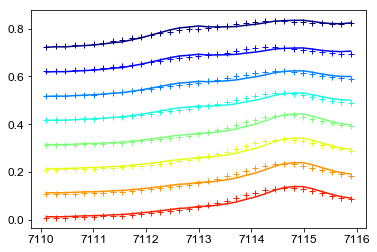

In [453]:
result20 = {}
colors = iter(cm.jet(numpy.linspace(0, 1, int(ylen))))
fmt = ' %25s   | %6.1f  +/- %6.1f | %6.6f'
print('%28s | %10s | %6s' % ("Series","Percent Fe (Error)","chisq"))
print("--------------------------------------------------------------")
for ct, (key, value) in enumerate(sorted(interp20.items())):
    data = numpy.array(value)
    # do fit, here with leastsq model
    minner = lmfit.Minimizer(resid, params, fcn_args=(data, eps))
    result = minner.minimize()
    Fe2 = result.params['ferrous']
    Fe3 = result.params['ferric']
    percent_ferric = Fe3.value / (Fe3.value + Fe2.value) * 100
    B = (numpy.sqrt((Fe3.stderr)**2 + (Fe2.stderr)**2)/ (Fe3.value + Fe2.value))**2
    A = (Fe3.stderr / Fe3.value)**2
    percent_err = 100*numpy.sqrt(A + B) 
    print(fmt % (key, percent_ferric, percent_err, result.chisqr))
    result20[key] = (percent_ferric, percent_err, result.chisqr)
    final = data + result.residual * eps
    offset = (ylen -2-ct)*0.1
    color = next(colors)
    plt.plot(energy, data + offset, 'k+',color=color )
    plt.plot(energy, final + offset, 'r', color=color)
plt.plot()
p = numpy.sum([x[1] for key,x in result20.items()]) / ylen2
ferric20 = numpy.array([x[0] for key,x in result20.items()])
ferror20 = numpy.array([x[1] for key,x in result20.items()])
print("--------------------------------------------------------------")
print("Average Std Error: " + str(p))

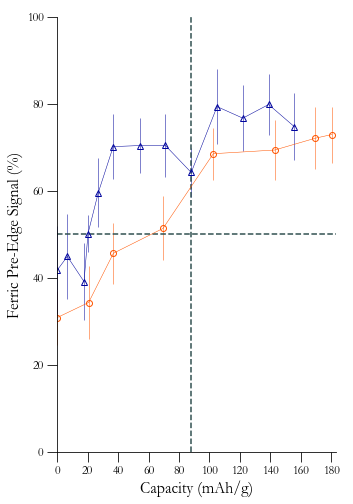

In [471]:
c_20_cap = [0, 20.703, 36.974, 69.513, 102.5, 142.73, 
            169.36, 180.25]
c_40_cap = [0, 6.772, 17.7232, 20.311, 27.082, 36.8549, 54.164, 
            71.09, 88.015, 104.96, 121.87, 138.79, 155.71]

fig = plt.figure()
fig.set_size_inches(5,8)
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'Garamond'})

ferricplt = fig.add_subplot(111, facecolor='white')
ferricplt.set_xlabel('Capacity (mAh/g)', color='k', fontsize=16, family='Garamond')
ferricplt.set_ylabel('Ferric Pre-Edge Signal (%)', color='k', fontsize=16, family='Garamond')
ferricplt.spines['top'].set_visible(False)
ferricplt.spines['right'].set_visible(False)
ferricplt.tick_params('both', length=10, which='major')
ferricplt.errorbar(c_20_cap, ferric20, yerr=ferror20, color='#ff5500', marker='o', 
               mfc='none',label='Charging at C/20', lw=0.5)
ferricplt.errorbar(c_40_cap, ferric40, yerr=ferror40, color='#00049d', marker='^', 
               mfc='none', label='Charging at C/40', lw=0.5)
ferricplt.set_xticks(numpy.round(numpy.linspace(0, 180, 10), 1))
ferricplt.set_yticks(numpy.round(numpy.linspace(0.0, 100, 6), 1))
ferricplt.axvline(x=88, color='darkslategrey', linestyle='--')
ferricplt.axhline(y=50, color='darkslategrey', linestyle='--')
ferricplt.set_xlim(0, 183)


plt.savefig('LCF.png', bbox_inches='tight', dpi=600)
plt.show()

In [464]:
covar40 = pd.read_csv('./covarC40.csv', index_col=0)
covar20 = pd.read_csv('./covarC20.csv', index_col=0)

In [467]:
covar40['ferric40'] = ferric40
covar20['ferric20'] = ferric20

In [470]:
covar40.to_csv('./covarC40.csv', sep=',')
covar20.to_csv('./covarC20.csv', sep=',')